In [1]:
from astropy import units as u
from astropy.coordinates import SkyCoord
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import quad
import multiprocessing as mp
import gc
import matplotlib.colors as colors
from matplotlib import rcParams 
from scipy.stats import gaussian_kde
from scipy.stats import binned_statistic_2d
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
plt.rc('font',size=25)
pd.set_option('max_column',200)

In [3]:
ms=pd.read_csv('../Downloads/catalog/final/starall_sm.csv')

In [4]:
len(ms)

619634

In [23]:
f=ms[ms.i_psfflux_mag>23.8]

In [26]:
len(f),len(f[f.Dkpc<1]),len(f[(f.Dkpc>1)&(f.Dkpc<3)]),len(f[(f.Dkpc>3)&(f.Dkpc<5)]),len(f[(f.Dkpc>5)&(f.Dkpc<7)]),len(f[(f.Dkpc>7)&(f.Dkpc<10)])

(15110, 163, 260, 264, 235, 390)

In [35]:
ff=f[(f.Dkpc<10)&(f.v_ra**2+f.v_dec**2>1000000)]

In [43]:
ff[ff.Dkpc<5]

,# object_id,i_extendedness_value,ra_1,dec_1,r_extendedness_value,i_sdsscentroid_ra,i_sdsscentroid_dec,i_sdsscentroid_rasigma,i_sdsscentroid_decsigma,g_cmodel_mag,r_cmodel_mag,i_cmodel_mag,z_cmodel_mag,g_cmodel_magsigma,r_cmodel_magsigma,i_cmodel_magsigma,z_cmodel_magsigma,g_psfflux_mag,r_psfflux_mag,i_psfflux_mag,z_psfflux_mag,g_psfflux_magsigma,r_psfflux_magsigma,i_psfflux_magsigma,z_psfflux_magsigma,a_g,a_r,a_i,a_z,mean_mjd,objID,ra_2,dec_2,type,rowc_r,colc_r,rowcErr_r,colcErr_r,u,g,r,i,z,err_u,err_g,err_r,err_i,err_z,psfmag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,psfmagerr_u,psfmagerr_g,psfmagerr_r,psfmagerr_i,psfmagerr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,S82_mean_mjd,Separation,delta_mjd,delta_yr,ra_s_error,dec_s_error,dra,ddec,dra_err,ddec_err,pmra,pmdec,pmra_err,pmdec_err,pmra_cl,pmdec_cl,ug,gr,FeH,Dkpc,pmra_cl_sm,pmdec_cl_sm,l,b,pm_lcosb,pm_b,pm_lcosb_sm,pm_b_sm,galcen_x,galcen_y,galcen_z,galcen_vx,galcen_vy,galcen_vz,v_ra,v_dec,v_b,v_lcosb,v_ra_sm,v_dec_sm,v_b_sm,v_lcosb_sm
99372,42634688648478787,0.0,-26.002908,1.195389,0.0,-26.002906,1.195389,0.014198,0.008349,26.962824,25.718014,24.005812,23.140833,0.234844,0.168583,0.02083,0.039981,26.982761,25.721052,24.002651,23.151386,0.23813,0.1664,0.020692,0.039498,0.138733,0.097456,0.069923,0.05408,57051.420003,8647475122504207084,-26.002785,1.195478,3,182.6417,1403.248,0.300357,0.41156,23.92777,26.01898,25.20635,22.54021,22.03223,0.703289,1.676572,1.258835,0.173605,0.390754,24.82766,28.84675,25.75187,23.57792,23.25243,0.641692,2.852326,0.818942,0.182521,0.48319,0.220729,0.16241,0.117793,0.089319,0.063328,53161.506413,0.540251,3889.91359,10.650295,0.118941,0.162978,-435.08191,-320.402261,119.785895,163.191409,-40.851632,-30.083887,11.247191,15.322713,-46.596414,-24.384487,-2.155101,1.261709,-0.6,4.434992,-49.239581,-16.378938,63.704205,-43.10444,-48.668248,19.930644,-44.247945,27.109506,-6.875351,2.902957,-3.008208,1056.251585,35.655985,309.783901,-980.318753,-513.013086,419.310898,-1023.907053,-1035.927045,-344.588332,570.343412,-930.910497


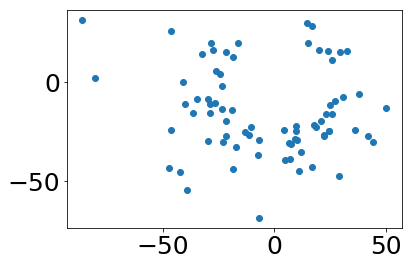

In [36]:
plt.scatter(ff.pmra_cl,ff.pmdec_cl)

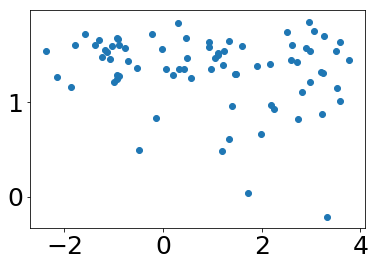

In [41]:
plt.scatter(ff.ug,ff.gr)

In [72]:
t=[]
tf=[]
j=0
for i in np.arange(21,24.1,0.5):
    t.append(ms[(ms.i_psfflux_mag>i)&(ms.i_psfflux_mag<i+0.5)])
    tf.append(t[j][(t[j].v_ra**2+t[j].v_dec**2>1000000)&(t[j].Dkpc<10)])
    j=j+1

In [61]:
a=pd.DataFrame(columns=('i_psfmag range','total num','D < 5 kpc & >1000km/s num','5 <D< 7 kpc & >1000km/s num','7<D<10 kpc & >1000km/s num'))
for i in range(7):
    a.loc[i]=[str(np.arange(21,24.1,0.5)[i])+'~'+str(np.arange(21,24.1,0.5)[i]+0.5),len(t[i]),len(t[i][(t[i].Dkpc<5)&(t[i].v_ra**2+t[i].v_dec**2>1000000)]),len(t[i][(t[i].Dkpc>5)&(t[i].Dkpc<7)&(t[i].v_ra**2+t[i].v_dec**2>1000000)]),len(t[i][(t[i].Dkpc>7)&(t[i].Dkpc<10)&(t[i].v_ra**2+t[i].v_dec**2>1000000)])]

In [65]:
a

,i_psfmag range,total num,D < 5 kpc & >1000km/s num,5 <D< 7 kpc & >1000km/s num,7<D<10 kpc & >1000km/s num
0,21.0~21.5,68614,11,17,19
1,21.5~22.0,70554,13,40,38
2,22.0~22.5,70762,9,34,107
3,22.5~23.0,67600,31,67,225
4,23.0~23.5,60384,14,99,441
5,23.5~24.0,32596,5,43,230
6,24.0~24.5,6765,1,6,18


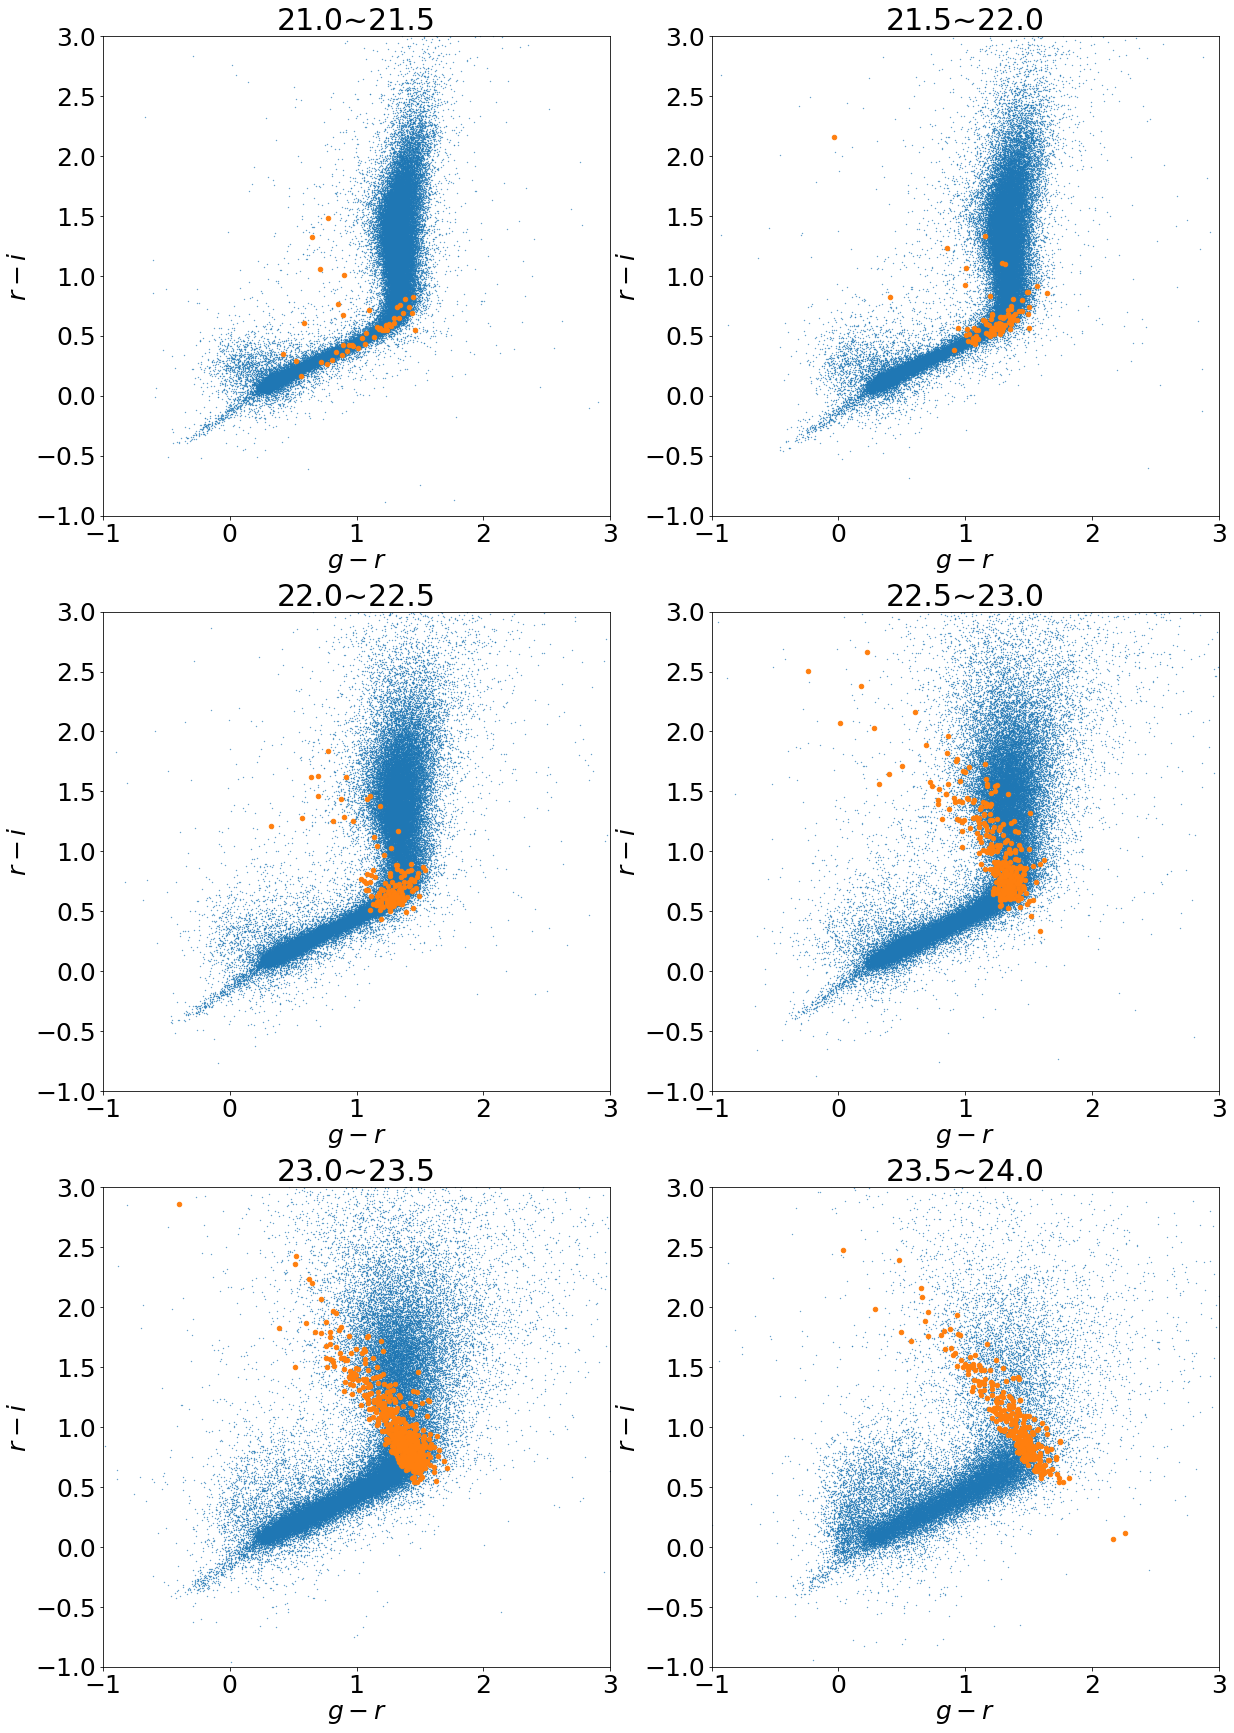

In [96]:
plt.figure(figsize=(20,30))
for i in range(6):
    plt.subplot(3,2,i+1)
    gr1=tf[i].gr
    ri1=tf[i].r_psfflux_mag-tf[i].i_psfflux_mag
    gr2=t[i].gr
    ri2=t[i].r_psfflux_mag-t[i].i_psfflux_mag
    plt.scatter(gr2,ri2,s=0.1)
    plt.scatter(gr1,ri1,s=20)
    plt.xlabel('$g-r$')
    plt.ylabel('$r-i$')
    plt.title(str(np.arange(21,24.1,0.5)[i])+'~'+str(np.arange(21,24.1,0.5)[i]+0.5))
    plt.xlim([-1,3])
    plt.ylim([-1,3])
plt.savefig('')

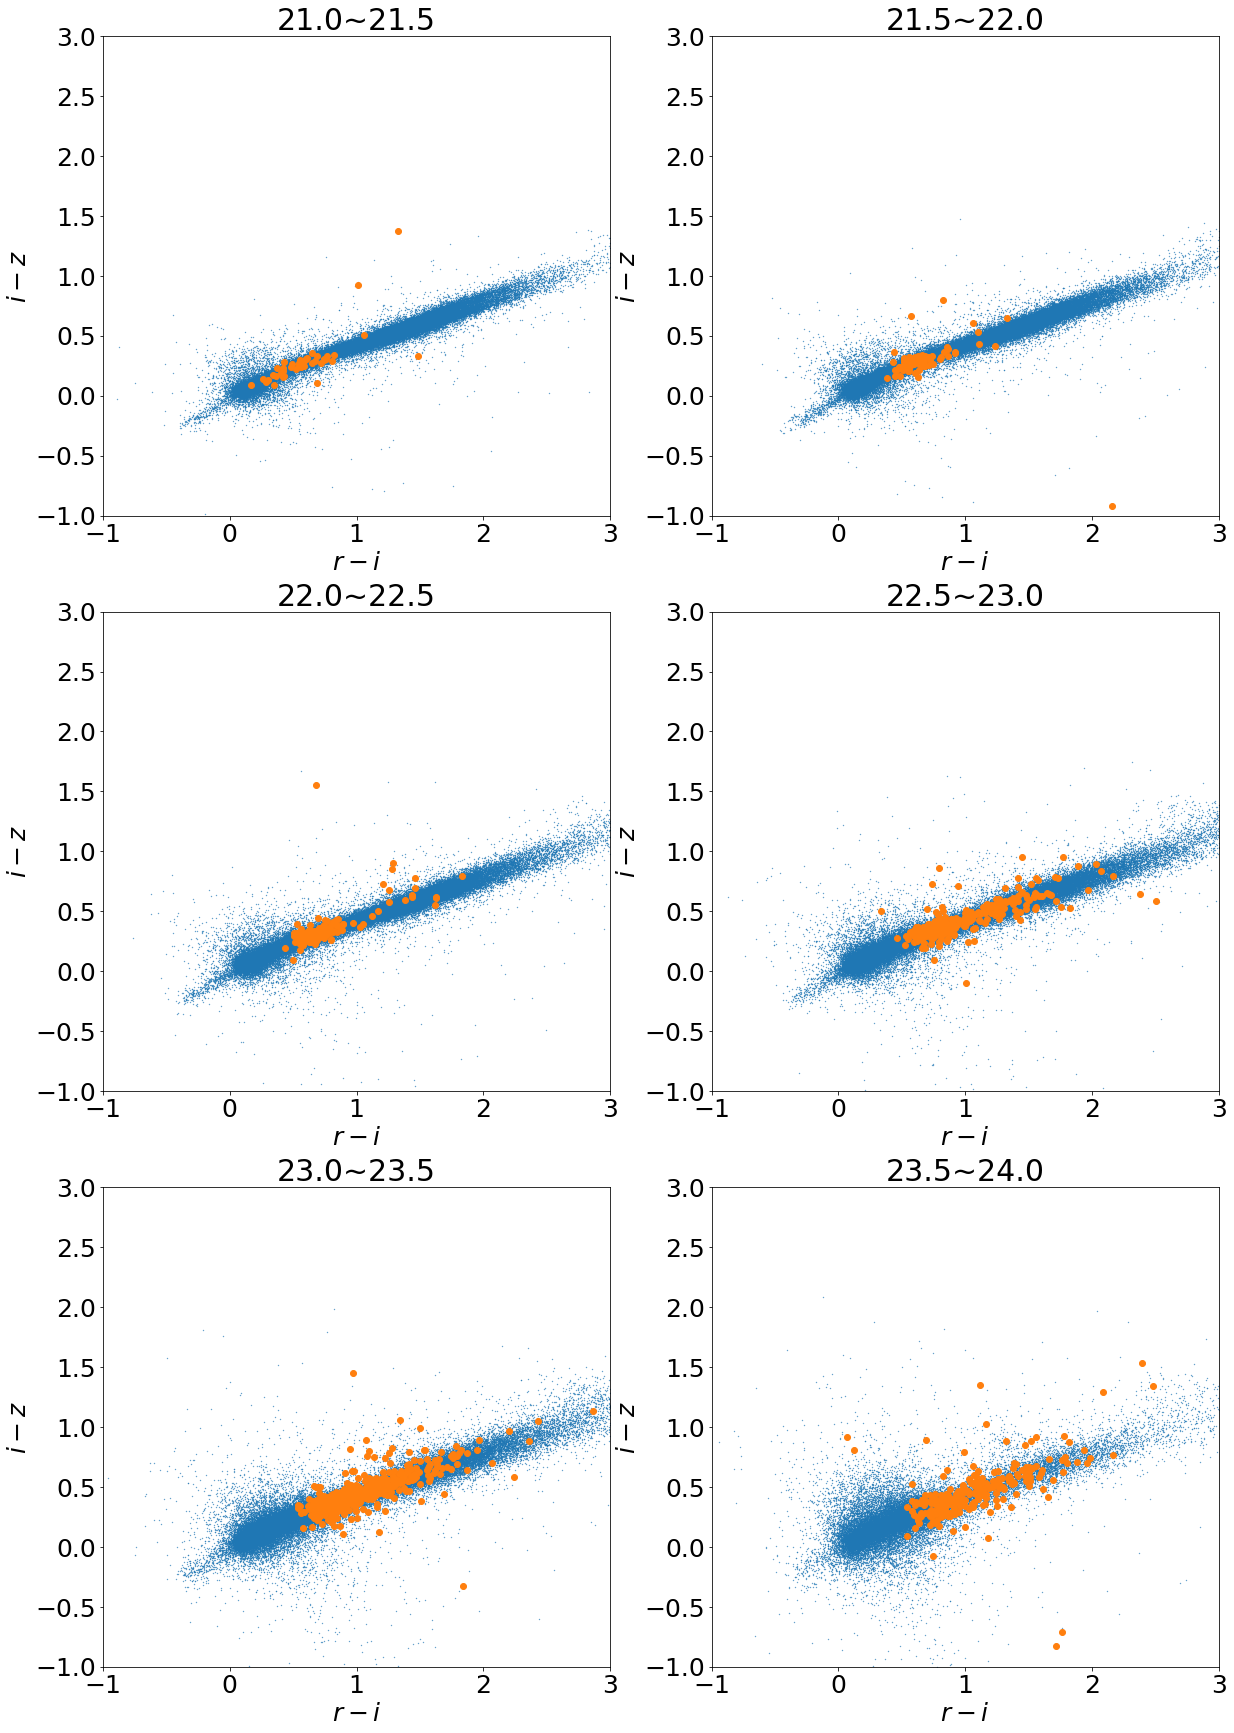

In [91]:
plt.figure(figsize=(20,30))
for i in range(6):
    plt.subplot(3,2,i+1)
    iz1=tf[i].i_psfflux_mag-tf[i].z_psfflux_mag
    ri1=tf[i].r_psfflux_mag-tf[i].i_psfflux_mag
    iz2=t[i].i_psfflux_mag-t[i].z_psfflux_mag
    ri2=t[i].r_psfflux_mag-t[i].i_psfflux_mag
    plt.scatter(ri2,iz2,s=0.1)
    plt.scatter(ri1,iz1)
    plt.xlabel('$r-i$')
    plt.ylabel('$i-z$')
    plt.title(str(np.arange(21,24.1,0.5)[i])+'~'+str(np.arange(21,24.1,0.5)[i]+0.5))
    plt.xlim([-1,3])
    plt.ylim([-1,3])